In [2]:
def calculate_maf_1000g(vcf_file):
    """
    计算 1000 Genomes 数据的次要等位基因频率 (MAF)，并过滤掉 MAF < 0.05 的 SNP。
    """
    # 提取 MAF 信息
    cmd = f"bcftools query -f '%CHROM:%POS\t%INFO/AF\n' {vcf_file}"
    print(f"Running command: {cmd}")
    output = subprocess.check_output(cmd, shell=True).decode().strip().split("\n")
    
    maf_data = []
    for line in output:
        snp, maf_values = line.split("\t")
        maf_values = maf_values.split(",")  # 处理多个频率值
        maf_values = [float(maf) for maf in maf_values]  # 转换为浮点数
        maf = sum(maf_values)  # 将次要等位基因频率相加
        if maf > 0.5:  # 转换为次要等位基因频率
            maf = 1 - maf
        maf_data.append((snp, maf))
    
    # 转换为 DataFrame
    maf_df = pd.DataFrame(maf_data, columns=["SNP", "MAF"])
    
    # 筛选 MAF >= 0.05 的 SNP
    filtered_maf_df = maf_df[maf_df["MAF"] >= 0.05].reset_index(drop=True)
    return filtered_maf_df

def main():
    # VCF 文件路径
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"
    
    # 计算 MAF 并过滤掉 MAF < 5% 的 SNP
    print("Calculating MAF for 1000 Genomes...")
    g1000_maf = calculate_maf_1000g(vcf_file)
    print(f"Number of SNPs after filtering (MAF >= 0.05): {len(g1000_maf)}")
    print(g1000_maf.head())
    
    # 保存过滤后的 MAF 数据
    g1000_maf.to_csv("filtered_maf_1000g.txt", sep="\t", index=False)
    print("Filtered MAF data saved as 'filtered_maf_1000g.txt'.")

if __name__ == "__main__":
    main()


Calculating MAF for 1000 Genomes...
Running command: bcftools query -f '%CHROM:%POS	%INFO/AF
' ../data/1000g/merged_common_snps.vcf.gz
Number of SNPs after filtering (MAF >= 0.05): 2407
          SNP       MAF
0  10:1214336  0.343850
1  10:1655794  0.106629
2  10:1935387  0.324281
3  10:3180298  0.235623
4  10:3389934  0.078275
Filtered MAF data saved as 'filtered_maf_1000g.txt'.


In [8]:
genotypes

NameError: name 'genotypes' is not defined

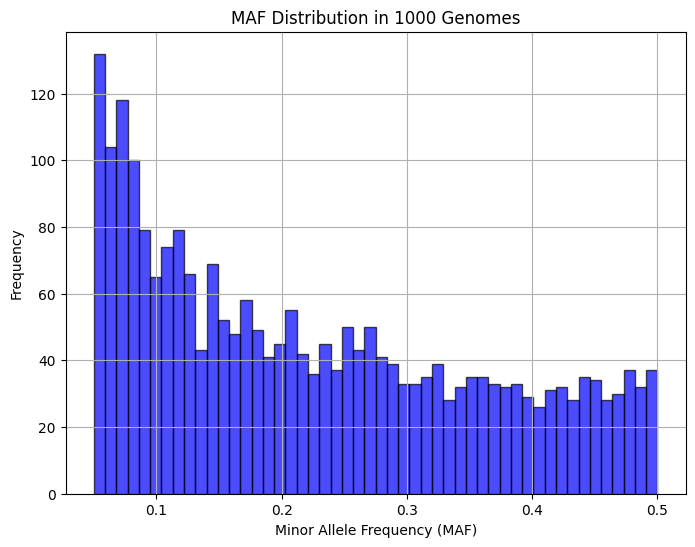

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_maf_distribution(maf_file, dataset_name="Dataset"):
    """
    绘制 MAF 分布的直方图
    """
    # 读取过滤的 MAF 数据
    maf_data = pd.read_csv(maf_file, sep="\t")
    
    # 绘制直方图
    plt.figure(figsize=(8, 6))
    plt.hist(maf_data["MAF"], bins=50, alpha=0.7, color="blue", edgecolor="k")
    plt.xlabel("Minor Allele Frequency (MAF)")
    plt.ylabel("Frequency")
    plt.title(f"MAF Distribution in {dataset_name}")
    plt.grid()
    plt.show()

def main():
    # 过滤后的 MAF 文件路径
    maf_file = "filtered_maf_1000g.txt"
    
    # 可视化
    plot_maf_distribution(maf_file, dataset_name="1000 Genomes")

if __name__ == "__main__":
    main()


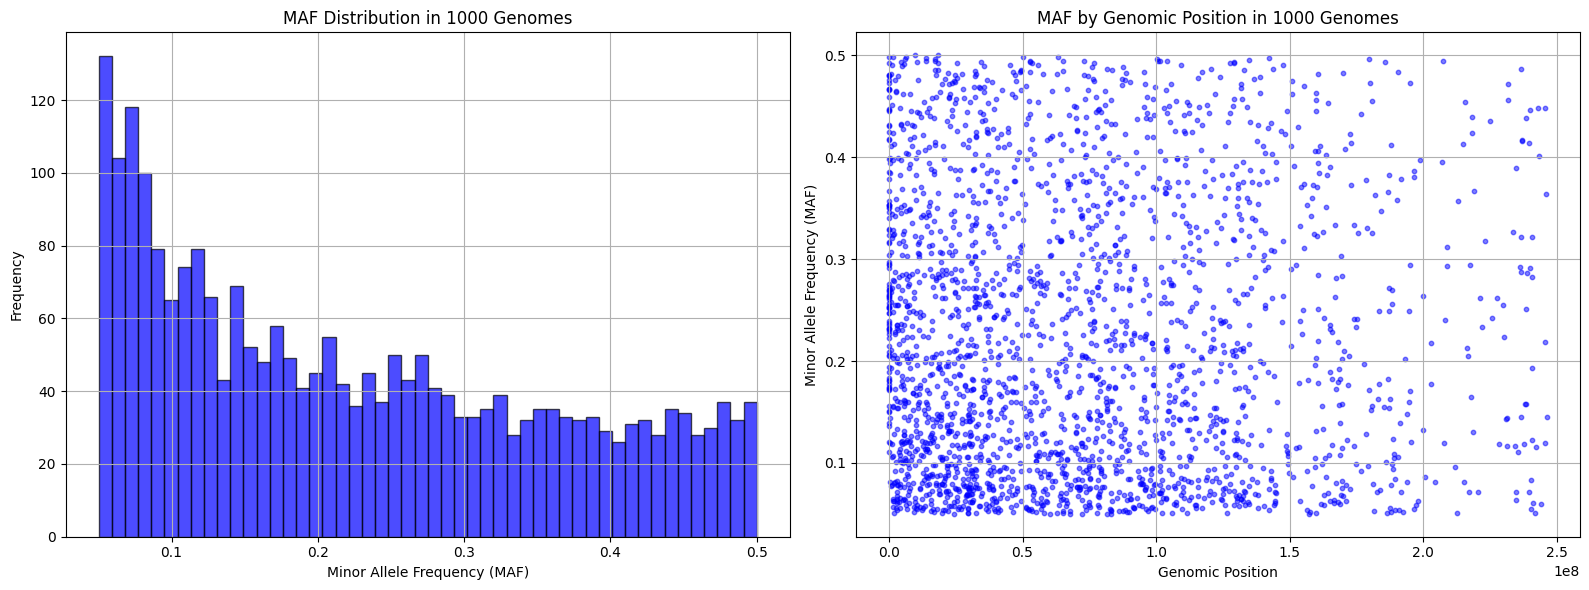

In [7]:
def plot_combined(maf_file, dataset_name="Dataset"):
    """
    绘制 MAF 分布和随染色体位置变化的图像
    """
    # 读取过滤的 MAF 数据
    maf_data = pd.read_csv(maf_file, sep="\t")
    
    # 拆分 SNP 为染色体和位置
    maf_data[["Chromosome", "Position"]] = maf_data["SNP"].str.split(":", expand=True)
    maf_data["Position"] = maf_data["Position"].astype(int)
    
    # 创建子图
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # 绘制直方图
    axs[0].hist(maf_data["MAF"], bins=50, alpha=0.7, color="blue", edgecolor="k")
    axs[0].set_xlabel("Minor Allele Frequency (MAF)")
    axs[0].set_ylabel("Frequency")
    axs[0].set_title(f"MAF Distribution in {dataset_name}")
    axs[0].grid()
    
    # 绘制散点图
    axs[1].scatter(maf_data["Position"], maf_data["MAF"], alpha=0.5, s=10, color="blue")
    axs[1].set_xlabel("Genomic Position")
    axs[1].set_ylabel("Minor Allele Frequency (MAF)")
    axs[1].set_title(f"MAF by Genomic Position in {dataset_name}")
    axs[1].grid()
    
    plt.tight_layout()
    plt.show()

def main():
    # 过滤后的 MAF 文件路径
    maf_file = "filtered_maf_1000g.txt"
    
    # 可视化
    plot_combined(maf_file, dataset_name="1000 Genomes")

if __name__ == "__main__":
    main()


In [2]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt

def load_vcf_and_extract_genotypes(vcf_file, max_snps=1000):
    """
    从 VCF 文件中提取基因型数据 (0/1/2 编码)
    参数：
        vcf_file: VCF 文件路径 (支持 .vcf.gz)
        max_snps: 最大提取的 SNP 数量
    返回：
        geno_data: 基因型矩阵 (行：SNP，列：样本)
        positions: 每个 SNP 的物理位置 (单位：bp)
    """
    geno_data = []
    positions = []

    with gzip.open(vcf_file, 'rt') if vcf_file.endswith('.gz') else open(vcf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):  # 跳过头部注释
                continue

            fields = line.strip().split("\t")
            chrom, pos, _, ref, alt, _, _, _, format_field, *genotypes = fields

            # 确认 GT 字段存在
            if 'GT' not in format_field:
                continue

            # 提取 GT (Genotype) 字段
            gt_index = format_field.split(':').index('GT')
            geno_row = []
            for g in genotypes:
                gt = g.split(':')[gt_index]
                if gt == './.':  # 缺失值处理
                    geno_row.append(np.nan)
                else:
                    alleles = list(map(int, gt.replace('|', '/').split('/')))  # 支持 | 和 / 分隔符
                    geno_row.append(sum(alleles))  # 0, 1, 2 编码

            geno_data.append(geno_row)
            positions.append(int(pos))

            if len(geno_data) >= max_snps:  # 限制最大 SNP 数量
                break

    geno_data = pd.DataFrame(geno_data).fillna(0)  # 填充缺失值为 0
    return geno_data, positions

def calculate_r2(geno1, geno2):
    """
    计算两个 SNP 之间的 LD (r^2)
    """
    p1 = np.mean(geno1) / 2
    p2 = np.mean(geno2) / 2
    p12 = np.mean(geno1 * geno2) / 4
    d = p12 - p1 * p2
    r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
    return r2

def calculate_ld_decay(geno_data, positions):
    """
    计算 SNP 两两之间的 LD 和物理距离
    参数：
        geno_data: 基因型矩阵 (行：SNP，列：样本)
        positions: 每个 SNP 的物理位置 (bp)
    返回：
        LD 数据框，包括 SNP 间的距离和 r^2
    """
    ld_results = []
    num_snps = geno_data.shape[0]
    for i in range(num_snps):
        for j in range(i + 1, num_snps):
            distance = abs(positions[i] - positions[j]) / 1000  # 转换为 kb
            r2 = calculate_r2(geno_data.iloc[i], geno_data.iloc[j])
            ld_results.append({"SNP1": i, "SNP2": j, "Distance_kb": distance, "R2": r2})
    return pd.DataFrame(ld_results)

def plot_ld_decay(ld_data):
    """
    绘制 LD 衰减曲线
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(ld_data["Distance_kb"], ld_data["R2"], alpha=0.5, s=10, color="blue")
    plt.xlabel("Distance between SNPs (kb)")
    plt.ylabel("Linkage Disequilibrium (R2)")
    plt.title("LD Decay Pattern")
    plt.grid(True)
    plt.show()

# 主函数
def main():
    # 输入 VCF 文件
    vcf_file = "../data/1000g/merged_common_snps.vcf.gz"  # 替换为实际路径

    # 提取基因型数据
    print("Extracting genotypes from VCF...")
    geno_data, positions = load_vcf_and_extract_genotypes(vcf_file, max_snps=1000)
    print(f"Extracted {len(positions)} SNPs.")

    # 计算 LD 和距离
    print("Calculating LD...")
    ld_data = calculate_ld_decay(geno_data, positions)
    print(f"Calculated LD for {len(ld_data)} SNP pairs.")

    # 绘制 LD 衰减曲线
    print("Plotting LD decay...")
    plot_ld_decay(ld_data)

if __name__ == "__main__":
    main()


Extracting genotypes from VCF...
Extracted 1000 SNPs.
Calculating LD...


/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1 - p2))
/tmp/ipykernel_83899/3148036058.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r2 = d**2 / (p1 * (1 - p1) * p2 * (1

KeyboardInterrupt: 

In [2]:
print(maf_data.columns)

NameError: name 'maf_data' is not defined